In [1]:
import pandas as pd
import numpy as np
import sys
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
filename = "../plddt_pfamseeds.json"

In [3]:
file = open(filename)
SeedPlddtDict = json.load(file)

In [5]:
Level1SummaryDict = {}

for key, value in SeedPlddtDict.items():
    PfInstance = key.split("_")[-1]
    if PfInstance in Level1SummaryDict.keys():
        PfDict = Level1SummaryDict[PfInstance]
    else:
        PfDict = {"meanlddt":[], "len":[], "LessThan50Frac":[],  "LessThan70Frac":[]}
    numpylddt = np.array(value)
    PfDict["meanlddt"].append(np.average(numpylddt))
    PfDict["len"].append(len(value))
    PfDict["LessThan50Frac"].append((numpylddt<50).sum())
    PfDict["LessThan70Frac"].append((numpylddt<70).sum())
    
    Level1SummaryDict[PfInstance] = PfDict


In [6]:
len(Level1SummaryDict)

18217

In [7]:
Level2SummaryDict = {}

for Pf, PfDict in Level1SummaryDict.items():
    SummaryOfPfDict = [np.average(y) for y in PfDict.values()]
    SummaryOfPfDict.append(len(PfDict["len"]))
    Level2SummaryDict[Pf] = SummaryOfPfDict

columns = ["pfam"] + ["avg_"+ x for x in list(list(Level1SummaryDict.values())[0].keys()) ] + ["NoOfInstances"]



In [8]:
df = pd.DataFrame.from_dict(Level2SummaryDict, orient='index').reset_index()
df.columns = columns

In [9]:
df.to_csv("../SummaryOfPfams.tsv", sep="\t", index=None)

# Retrieval proportion for Pfam Seeds
To this end, we have stored all the summary of plddt of structures of each pfam separately.
Now, we want to plot the mean plddt and the mean size of the pfams

In [13]:
PfamSummary = pd.read_csv("../SummaryOfPfams.tsv",sep="\t")

In [14]:
PfamSummary["avg_meanlddt"].describe()

count    18217.000000
mean        83.388367
std         13.574650
min         24.606909
25%         79.594231
50%         87.820392
75%         92.679821
max         98.554571
Name: avg_meanlddt, dtype: float64

In [15]:
PfamSummary["avg_len"].describe()

count    18217.000000
mean       166.470746
std        133.185205
min          8.000000
25%         81.166667
50%        128.000000
75%        209.000000
max       1776.666667
Name: avg_len, dtype: float64

87.82039238674359
[79.59423077 92.67982097]
128.0
[ 81.16666667 209.        ]


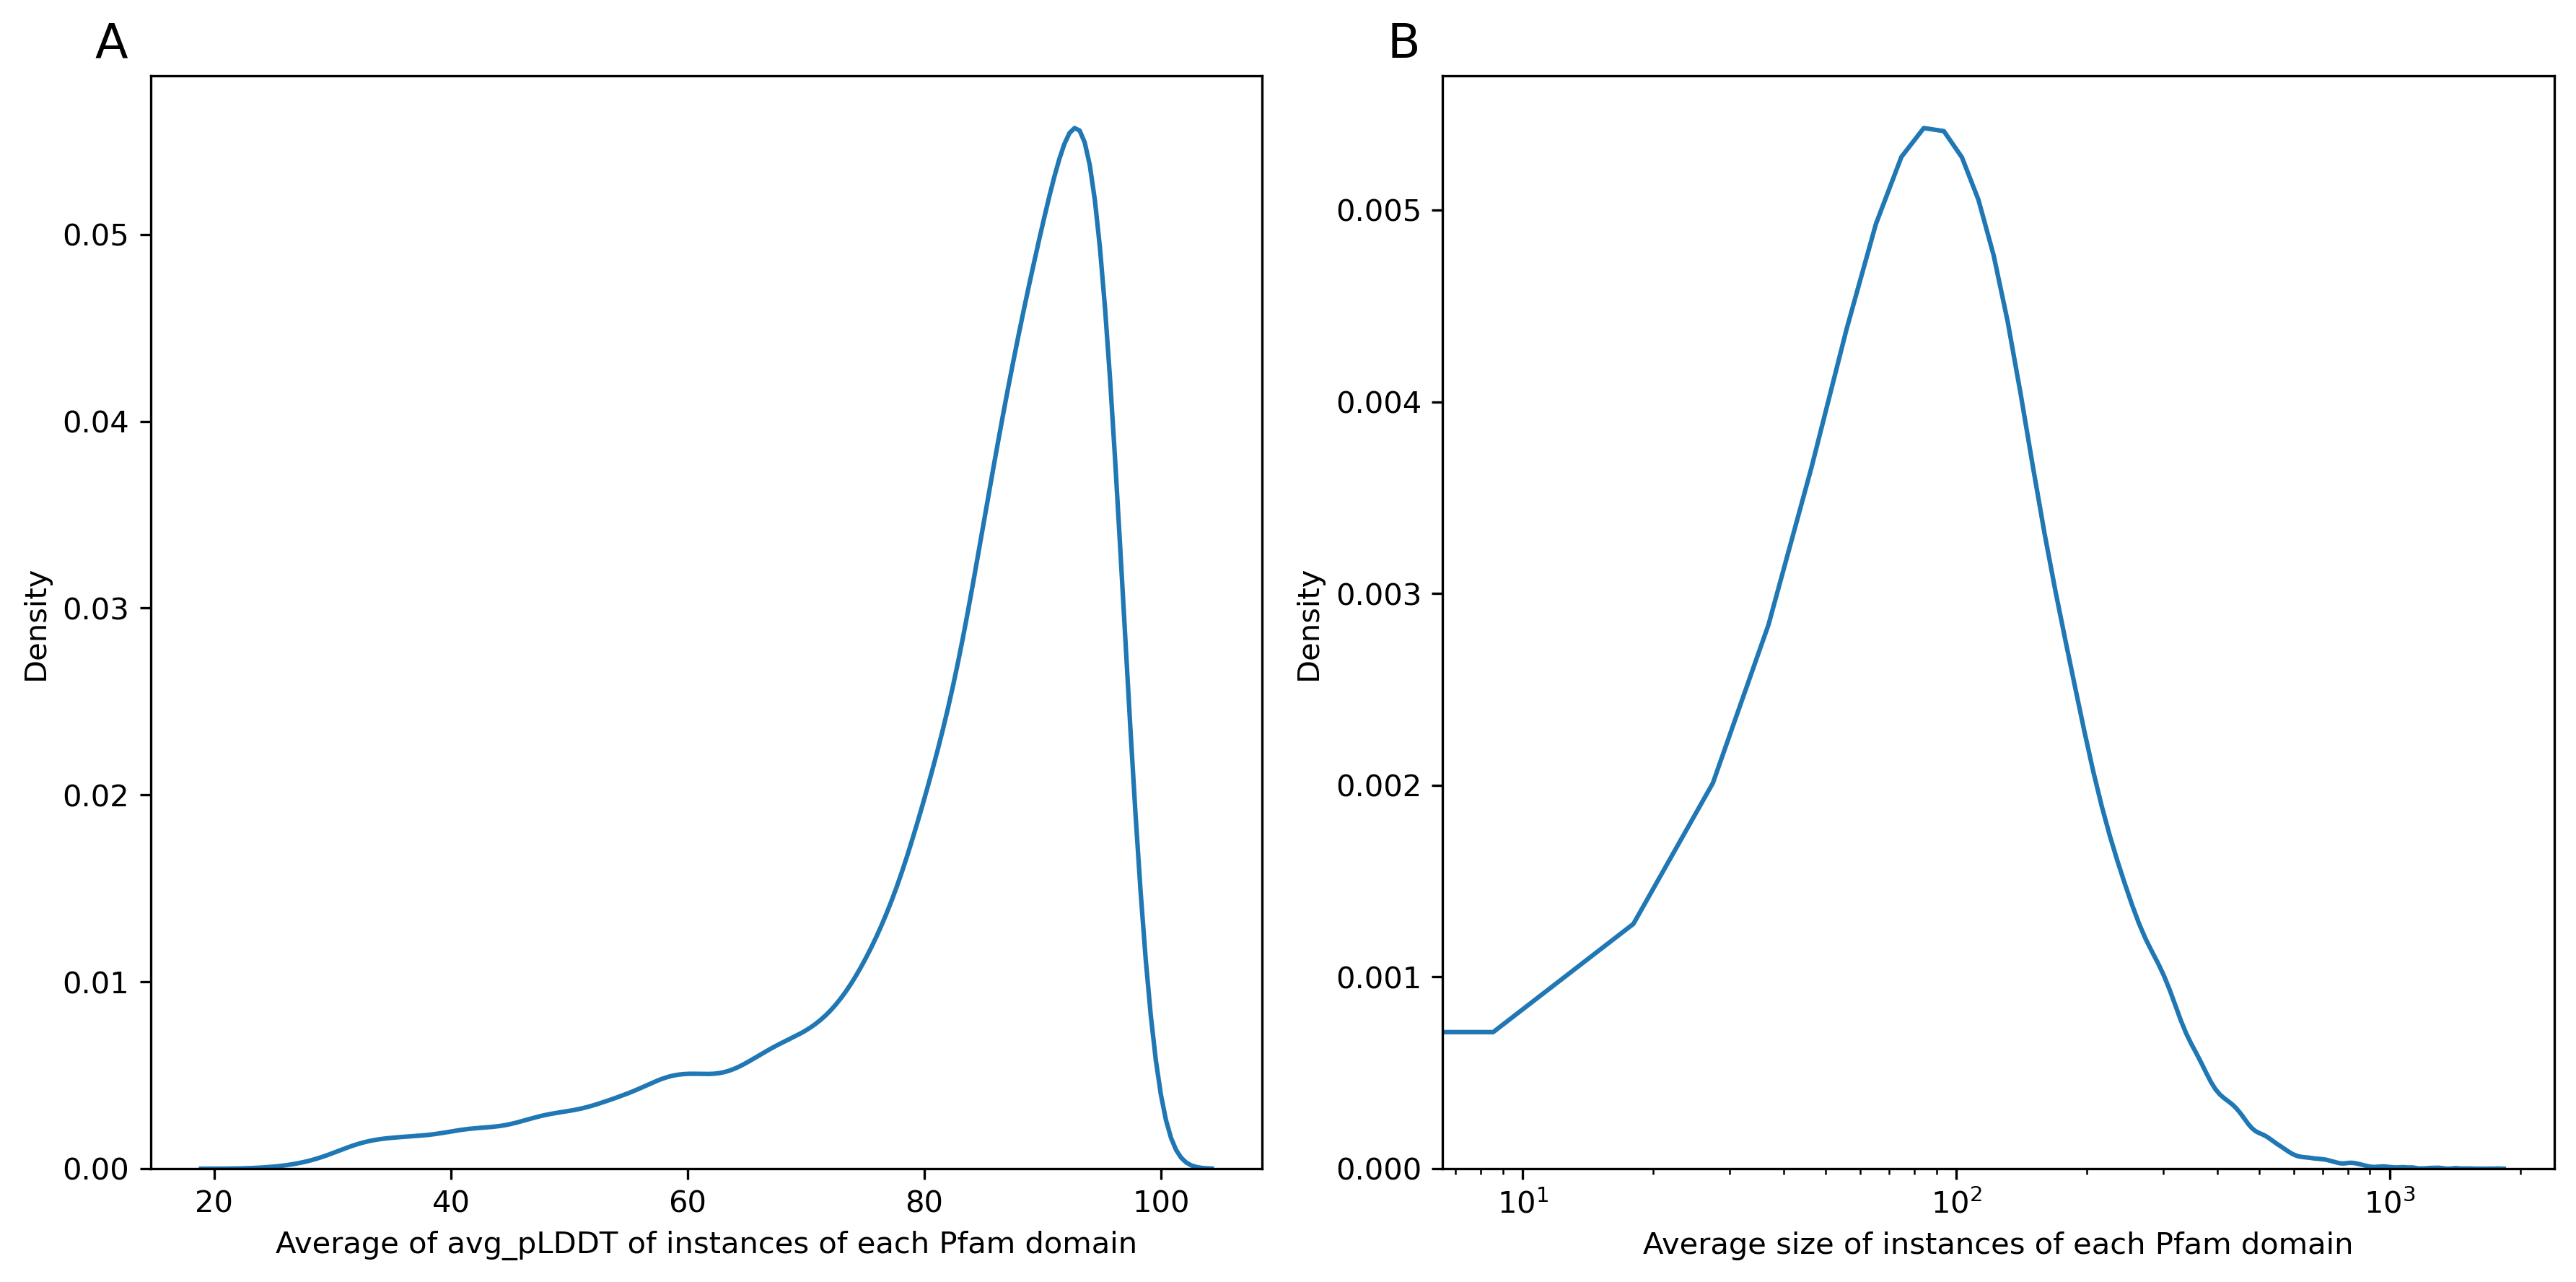

In [20]:
avg_meanlddt = PfamSummary["avg_meanlddt"]
avg_len = PfamSummary["avg_len"]

# Create a figure and a set of subplots with a higher DPI
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# Create the first plot
sns.kdeplot(ax=axes[0], data=avg_meanlddt)
#axes[0].set_title('Kernel Density Estimation of the average pLDDT')
axes[0].set_xlabel('Average of avg_pLDDT of instances of each Pfam domain')
axes[0].set_ylabel('Density')

data = avg_meanlddt
median = np.median(data)
quantiles = np.quantile(data, [0.25, 0.75])  # Change these values to whichever quantiles you need
print(median)
print(quantiles)
"""
axes[0].axvline(median, color='red', linestyle='dashed', linewidth=2, label=f'median: {median:.2f}')
axes[0].axvline(quantiles[0], color='green', linestyle='dashed', linewidth=2, label=f'25th percentile: {quantiles[0]:.2f}')
axes[0].axvline(quantiles[1], color='purple', linestyle='dashed', linewidth=2, label=f'75th percentile: {quantiles[1]:.2f}')

"""

axes[0].text(-0.05, 1.05, 'A', transform=axes[0].transAxes, fontsize=16, va='top')
# Create the second plot
sns.kdeplot(ax=axes[1], data=avg_len)
#axes[1].set_title('Kernel Density Estimation of the average size')
axes[1].set_xlabel('Average size of instances of each Pfam domain')
axes[1].set_xscale('log')
axes[1].text(-0.05, 1.05, 'B', transform=axes[1].transAxes, fontsize=16, va='top')

data = avg_len
median = np.median(data)
quantiles = np.quantile(data, [0.25, 0.75])  # Change these values to whichever quantiles you need
print(median)
print(quantiles)
"""
axes[1].axvline(median, color='red', linestyle='dashed', linewidth=2, label=f'median: {median:.2f}')
axes[1].axvline(quantiles[0], color='green', linestyle='dashed', linewidth=2, label=f'25th percentile: {quantiles[0]:.2f}')
axes[1].axvline(quantiles[1], color='purple', linestyle='dashed', linewidth=2, label=f'75th percentile: {quantiles[1]:.2f}')
"""
#axes[1].set_ylabel('Density')

# Display the plots
plt.tight_layout()
plt.show()


In [17]:
#NegAndPosHitsDF = pd.read_csv("../NoOfPosAndNegHitsStratifiedByPF_e0.001.tsv", sep="\t")
NegAndPosHitsDF = pd.read_csv("../TF_by_PF_summary.csv", sep="\t")
PfamSummaryAndPosNegCount = PfamSummary.merge(NegAndPosHitsDF, left_on="pfam", right_on="pf", how='left').drop(columns=["pf"]).fillna(0)
PfamSummaryAndPosNegCount["NoOfPosHitsNormByMembers"] = PfamSummaryAndPosNegCount['1']/(PfamSummaryAndPosNegCount["NoOfInstances"]*PfamSummaryAndPosNegCount["NoOfInstances"])
df = PfamSummaryAndPosNegCount[["avg_meanlddt","avg_len", "NoOfPosHitsNormByMembers" ]]

Text(-0.1, 1, 'B')

<Figure size 7680x5760 with 0 Axes>

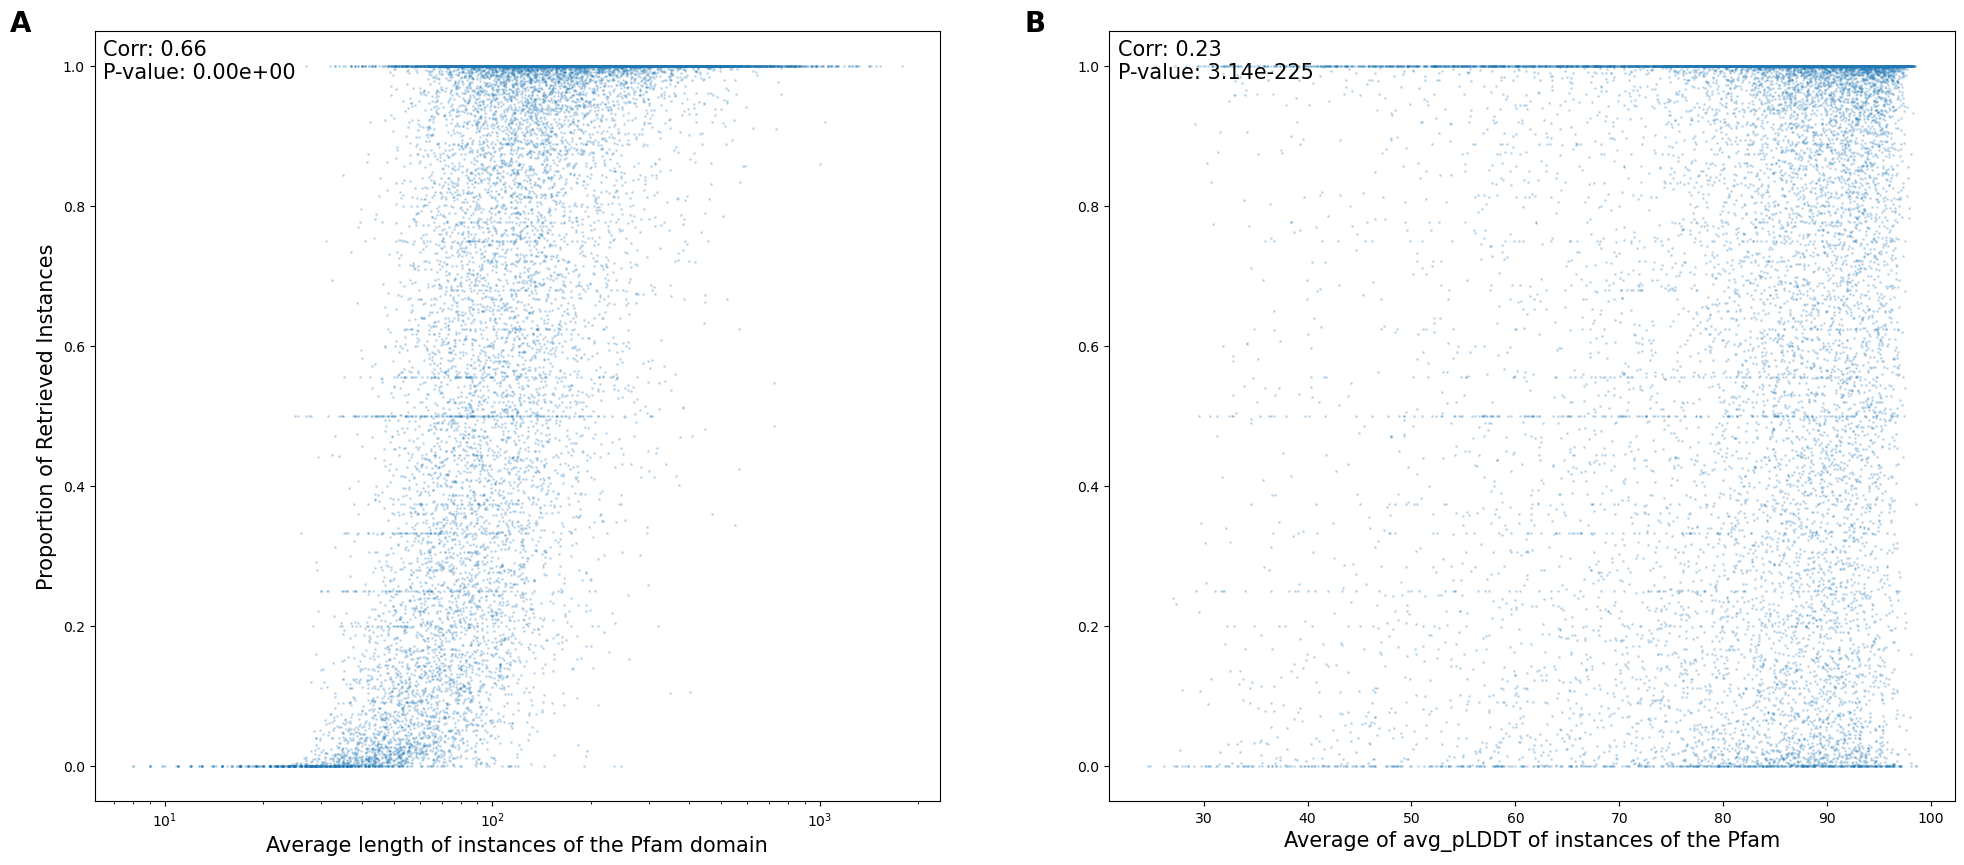

In [21]:
plt.figure(dpi=1200)
#sns.lmplot(data=df,x="avg_meanlddt", y="NoOfPosHitsNormByMembers")
plt.figure(figsize=(24, 10))

plt.subplot(1, 2, 1)

plt.scatter(x=PfamSummaryAndPosNegCount["avg_len"],y=PfamSummaryAndPosNegCount["NoOfPosHitsNormByMembers"], alpha=0.2,s=1 )
plt.xlabel( 'Average length of instances of the Pfam domain', fontsize=15) #r'$\it{Log}$' +
plt.ylabel('Proportion of Retrieved Instances', fontsize=15)
plt.gca().set_xscale('log')

corr, p_value = stats.spearmanr(PfamSummaryAndPosNegCount["avg_len"], PfamSummaryAndPosNegCount["NoOfPosHitsNormByMembers"])

plt.text(0.01, 0.99, f'Corr: {corr:.2f}\nP-value: {p_value:.2e}', #:.3f
         verticalalignment='top', horizontalalignment='left',
         transform=plt.gca().transAxes,
         color='black', fontsize=15)
plt.text(-0.1, 1, 'A', transform=plt.gca().transAxes, 
            size=20, weight='bold')

plt.subplot(1, 2, 2)
plt.scatter(x=PfamSummaryAndPosNegCount["avg_meanlddt"],y=PfamSummaryAndPosNegCount["NoOfPosHitsNormByMembers"], alpha=0.2,s=1 )

plt.xlabel("Average of avg_pLDDT of instances of the Pfam", fontsize=15)

corr, p_value = stats.spearmanr(PfamSummaryAndPosNegCount["avg_meanlddt"], PfamSummaryAndPosNegCount["NoOfPosHitsNormByMembers"])
plt.text(0.01, 0.99, f'Corr: {corr:.2f}\nP-value: {p_value:.2e}', 
         verticalalignment='top', horizontalalignment='left',
         transform=plt.gca().transAxes,
         color='black', fontsize=15)
plt.text(-0.1, 1, 'B', transform=plt.gca().transAxes, 
            size=20, weight='bold')


In [19]:
PfamSummaryAndPosNegCount[((PfamSummaryAndPosNegCount["avg_meanlddt"]>80) &(PfamSummaryAndPosNegCount["avg_len"]>100))&
                         (PfamSummaryAndPosNegCount["NoOfPosHitsNormByMembers"]==0)]

,pfam,avg_meanlddt,avg_len,avg_LessThan50Frac,avg_LessThan70Frac,NoOfInstances,0,1,NoOfPosHitsNormByMembers
2259,PF00261,93.026275,236.000000,0.941176,9.411765,17,0.0,0.0,0.0
7114,PF06320,97.024948,113.558824,0.000000,0.147059,34,0.0,0.0,0.0
8642,PF14662,95.109453,190.166667,0.000000,3.166667,6,0.0,0.0,0.0
11104,PF12718,95.921818,143.416667,0.000000,0.375000,24,0.0,0.0,0.0
15509,PF06705,92.267072,246.666667,1.666667,12.333333,3,0.0,0.0,0.0
17777,PF09304,94.639626,107.000000,0.000000,0.000000,3,0.0,0.0,0.0
18059,PF07439,83.483533,112.500000,0.500000,13.500000,2,0.0,0.0,0.0
